# Khởi tạo Spark Session

In [ ]:
import os
# Thiết lập này trước khi import pyspark
os.environ['SPARK_LOCAL_IP'] = '127.0.0.1'

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt

# Khởi tạo phiên Spark
spark = SparkSession.builder \
    .appName("Grocery Order Analysis") \
    .master("local[*]") \
    .getOrCreate()

# Đọc file CSV vào Spark DataFrame
spark_df = spark.read.csv(r"data\marketing_campain_data.csv", header=True, inferSchema=True)

# Hiển thị schema để hiểu cấu trúc dữ liệu
spark_df.printSchema()

# Hiển thị vài dòng để xác nhận dữ liệu đã được tải đúng
spark_df.show(5)

root
 |-- order_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- product_name: string (nullable = true)

+--------+-------+------------+---------+-----------------+----------------------+----------+-----------------+---------+-------------+----------+------------------+
|order_id|user_id|order_number|order_dow|order_hour_of_day|days_since_prior_order|product_id|add_to_cart_order|reordered|department_id|department|      product_name|
+--------+-------+------------+---------+-----------------+----------------------+----------+-----------------+---------+--

# Phân tích dữ liệu cơ bản

In [ ]:
# Lấy thống kê cơ bản về dữ liệu
print("Total number of records:", spark_df.count())
print("Number of columns:", len(spark_df.columns))

# Thống kê tóm tắt cho các cột số
spark_df.describe().show()

# Kiểm tra giá trị bị thiếu
for column in spark_df.columns:
    missing_count = spark_df.filter(col(column).isNull()).count()
    print(f"Column {column}: {missing_count} missing values")

Total number of records: 2019501
Number of columns: 12
+-------+------------------+------------------+------------------+------------------+------------------+----------------------+------------------+-----------------+------------------+-----------------+----------+--------------------+
|summary|          order_id|           user_id|      order_number|         order_dow| order_hour_of_day|days_since_prior_order|        product_id|add_to_cart_order|         reordered|    department_id|department|        product_name|
+-------+------------------+------------------+------------------+------------------+------------------+----------------------+------------------+-----------------+------------------+-----------------+----------+--------------------+
|  count|           2019501|           2019501|           2019501|           2019501|           2019501|               1895159|           2019501|          2019501|           2019501|          2019501|   2019501|             2019501|
|   mean|

In [ ]:
# 1. Sản phẩm phổ biến nhất (theo số lượng đơn hàng)
popular_products = spark_df.groupBy("product_name") \
    .count() \
    .orderBy("count", ascending=False)

print("Top 10 most popular products:")
popular_products.show(10)

# 2. Phân bố đơn hàng theo phòng ban
dept_distribution = spark_df.groupBy("department") \
    .count() \
    .orderBy("count", ascending=False)

print("Orders by department:")
dept_distribution.show()

# 3. Phân tích mô hình đặt hàng lại
reorder_analysis = spark_df.groupBy("product_name") \
    .agg(
        sum("reordered").alias("total_reorders"),
        count("*").alias("total_orders"),
        (sum("reordered") / count("*")).alias("reorder_ratio")
    ) \
    .orderBy("reorder_ratio", ascending=False)

print("Products with highest reorder ratio:")
reorder_analysis.filter(col("total_orders") > 10).show(10)

# 4. Phân tích mô hình thời gian đặt hàng
hour_distribution = spark_df.groupBy("order_hour_of_day") \
    .count() \
    .orderBy("order_hour_of_day")

print("Orders by hour of day:")
hour_distribution.show(24)

Top 10 most popular products:
+--------------------+------+
|        product_name| count|
+--------------------+------+
|        fresh fruits|226039|
|    fresh vegetables|212611|
|packaged vegetabl...|109596|
|              yogurt| 90751|
|     packaged cheese| 61502|
|                milk| 55150|
|water seltzer spa...| 52564|
|      chips pretzels| 45306|
|     soy lactosefree| 39389|
|               bread| 36381|
+--------------------+------+
only showing top 10 rows

Orders by department:
+---------------+------+
|     department| count|
+---------------+------+
|        produce|588996|
|     dairy eggs|336915|
|         snacks|180692|
|      beverages|168126|
|         frozen|139536|
|         pantry|116262|
|         bakery| 72983|
|   canned goods| 66053|
|           deli| 65176|
|dry goods pasta| 54054|
|      household| 46446|
|      breakfast| 44605|
|   meat seafood| 44271|
|  personal care| 28134|
|         babies| 25940|
|  international| 16738|
|        alcohol|  9439|
| 

# Phân tích nâng cao với Spark SQL

In [ ]:
# Chuyển DataFrame thành một bảng SQL tạm thời
spark_df.createOrReplaceTempView("orders")

# Ví dụ: Tìm người dùng đặt hàng với nhiều loại sản phẩm nhất
user_product_variety = spark.sql("""
    SELECT user_id, COUNT(DISTINCT product_id) as variety
    FROM orders
    GROUP BY user_id
    ORDER BY variety DESC
    LIMIT 10
""")

print("Users with most varied product selections:")
user_product_variety.show()

# Tìm các phòng ban nào thường được mua cùng nhau
# Điều này yêu cầu tự kết nối (self-join)
spark.sql("""
    SELECT a.department as dept1, b.department as dept2, COUNT(*) as combo_count
    FROM orders a JOIN orders b
    ON a.order_id = b.order_id AND a.department < b.department
    GROUP BY dept1, dept2
    ORDER BY combo_count DESC
    LIMIT 10
""").show()

Users with most varied product selections:
+-------+-------+
|user_id|variety|
+-------+-------+
| 160693|     60|
| 186537|     59|
|  15503|     59|
|  56717|     57|
| 180203|     57|
|  10156|     57|
|  32099|     56|
|   2335|     56|
| 174419|     56|
|  43758|     55|
+-------+-------+

+------------+----------+-----------+
|       dept1|     dept2|combo_count|
+------------+----------+-----------+
|  dairy eggs|   produce|    1368937|
|     produce|    snacks|     631611|
|      frozen|   produce|     518111|
|   beverages|   produce|     501213|
|      pantry|   produce|     478288|
|  dairy eggs|    snacks|     437367|
|   beverages|dairy eggs|     350572|
|  dairy eggs|    frozen|     332609|
|canned goods|   produce|     313056|
|      bakery|   produce|     283813|
+------------+----------+-----------+



# Trực quan hóa dữ liệu

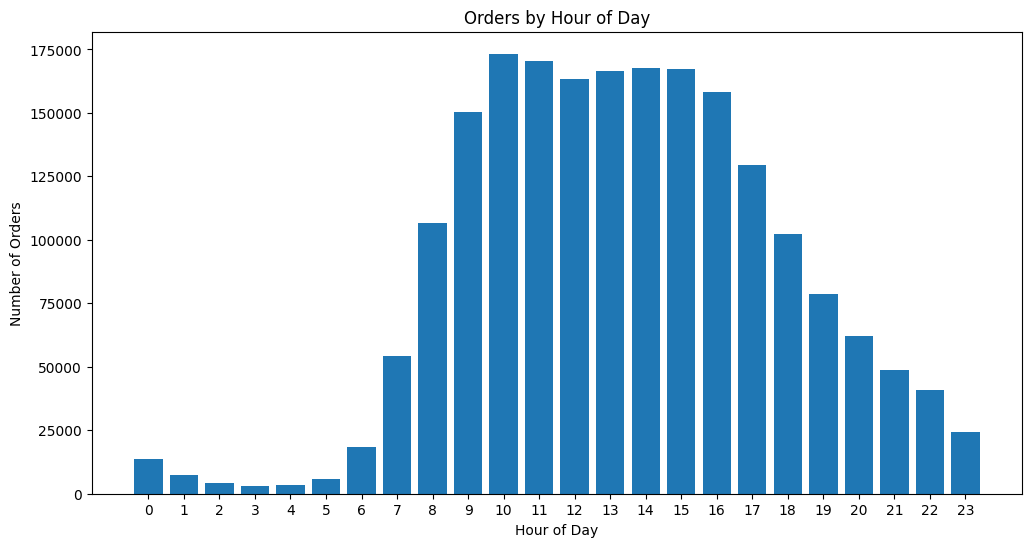

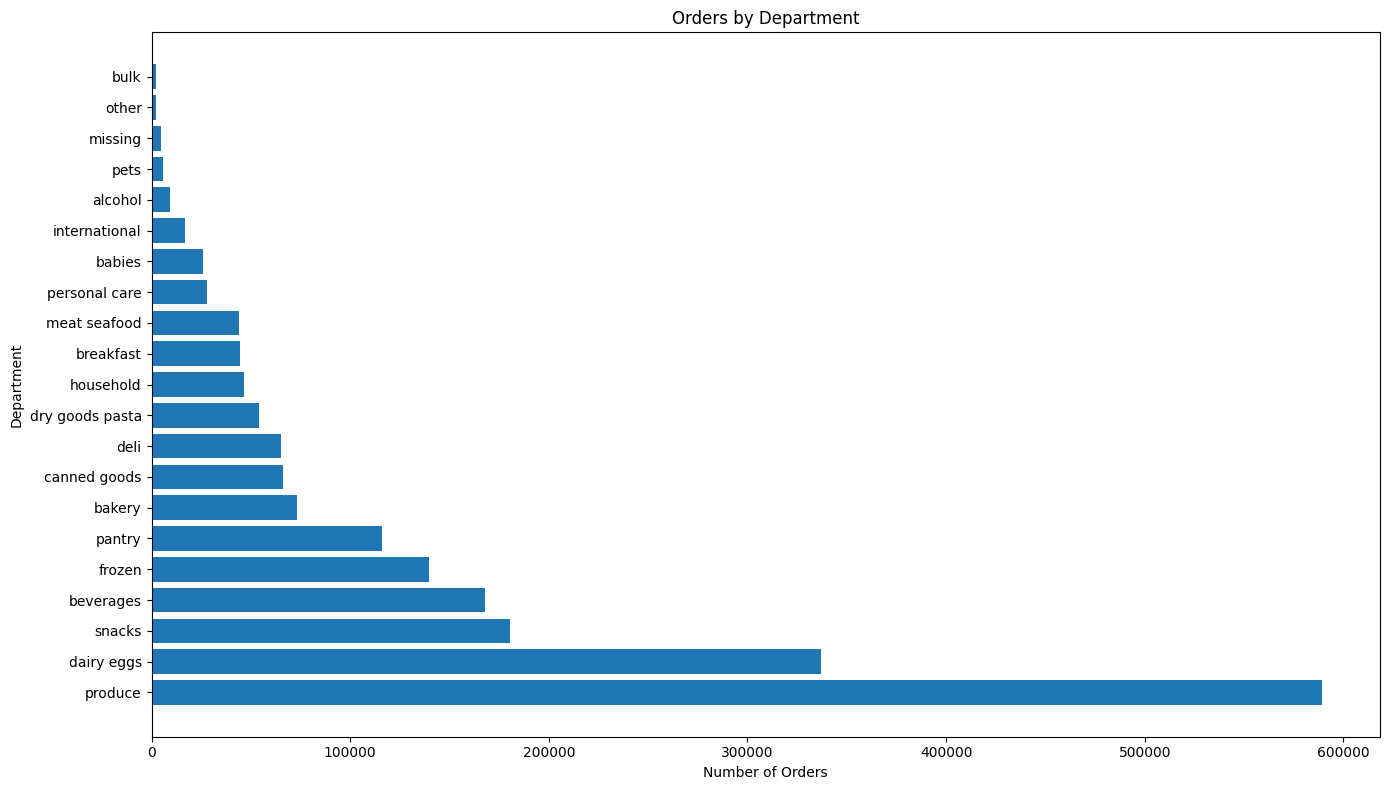

In [ ]:
# Chuyển đổi sang pandas để trực quan hóa
hour_pd = hour_distribution.toPandas()
dept_pd = dept_distribution.toPandas()

# Vẽ biểu đồ đơn hàng theo giờ
plt.figure(figsize=(12, 6))
plt.bar(hour_pd['order_hour_of_day'], hour_pd['count'])
plt.title('Orders by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.xticks(range(0, 24))
plt.savefig('orders_by_hour.png')

# Vẽ biểu đồ đơn hàng theo phòng ban
plt.figure(figsize=(14, 8))
plt.barh(dept_pd['department'], dept_pd['count'])
plt.title('Orders by Department')
plt.xlabel('Number of Orders')
plt.ylabel('Department')
plt.tight_layout()
plt.savefig('orders_by_department.png')

# Xây dựng hệ thống gợi ý

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Chuẩn bị dữ liệu cho hệ thống gợi ý
# Chuyển user_id và product_id sang kiểu số nếu chưa phải số
recommendation_data = spark_df.select(
    col("user_id").cast("integer"),
    col("product_id").cast("integer"),
    col("reordered").cast("float")  # Sử dụng reordered làm đánh giá ngầm
)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
(training, test) = recommendation_data.randomSplit([0.8, 0.2])

# Xây dựng mô hình gợi ý dùng ALS
als = ALS(
    maxIter=5,
    regParam=0.01,
    userCol="user_id",
    itemCol="product_id",
    ratingCol="reordered",
    coldStartStrategy="drop"
)

model = als.fit(training)

# Dự đoán
predictions = model.transform(test)
predictions.show(5)

# Đánh giá mô hình
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="reordered",
    predictionCol="prediction"
)
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

# Tạo ra 5 gợi ý sản phẩm hàng đầu cho mỗi khách hàng
userRecs = model.recommendForAllUsers(5)
userRecs.show(5)

+-------+----------+---------+------------+
|user_id|product_id|reordered|  prediction|
+-------+----------+---------+------------+
|   1645|        83|      0.0|  0.10065784|
|   1645|        91|      1.0|   1.0303519|
|   1645|       121|      0.0|  0.87657636|
|   4900|        17|      1.0|-0.010298904|
|   4900|        92|      1.0|   0.6775957|
+-------+----------+---------+------------+
only showing top 5 rows

Root-mean-square error = 0.47732473359126687
+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|     31|[{7, 0.89568806},...|
|     34|[{31, 0.9651209},...|
|     65|[{34, 1.3069035},...|
|     78|[{50, 0.0}, {49, ...|
|    108|[{50, 0.0}, {49, ...|
+-------+--------------------+
only showing top 5 rows



In [ ]:
# Lưu kết quả dưới dạng tệp parquet (định dạng hiệu quả cho dữ liệu lớn)
popular_products.write.parquet("results/popular_products2.parquet")
dept_distribution.write.parquet("results/dept_distribution2.parquet")

# Lưu ra tệp CSV
popular_products.write.csv("results/popular_products2.csv", header=True)

# Phân tích chiến dịch marketing
## Đề xuất sản phẩm cho từng khách hàng

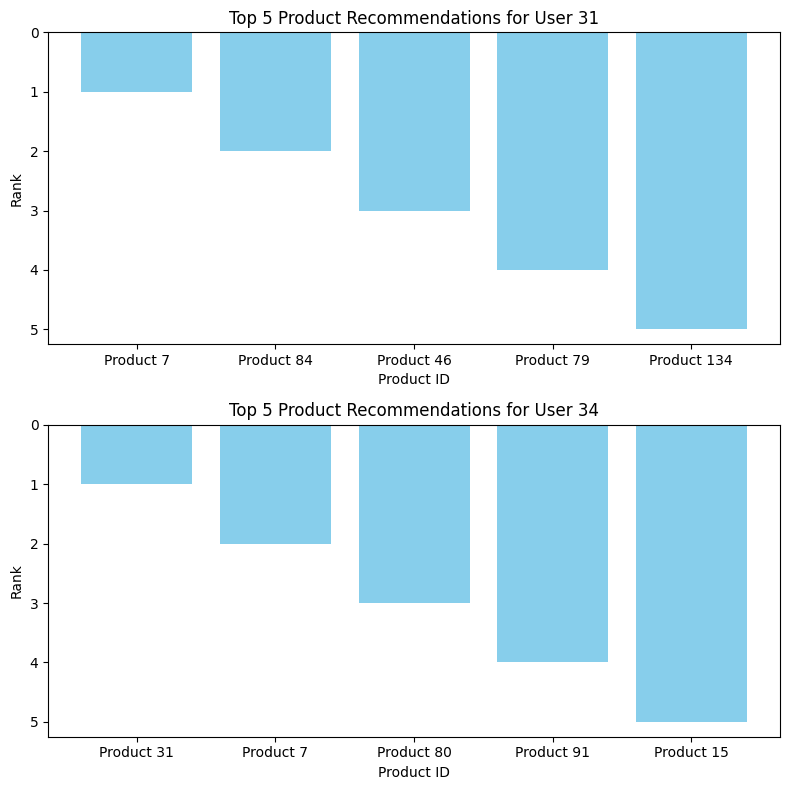

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Chuyển đổi danh sách gợi ý sang Pandas DataFrame để dễ trực quan hóa
userRecs_pd = userRecs.select("user_id", "recommendations.product_id").toPandas()

# Chọn một vài người dùng để trực quan hóa 5 gợi ý sản phẩm hàng đầu của họ
sample_users = userRecs_pd.head(2)

# Tạo biểu đồ cột cho mỗi người dùng hiển thị các sản phẩm được gợi ý hàng đầu
fig, ax = plt.subplots(len(sample_users), 1, figsize=(8, len(sample_users) * 4))

for i, row in sample_users.iterrows():
    user_id = row['user_id']
    recommended_products = row['product_id']  # Lấy danh sách các sản phẩm được gợi ý
    
    # Chuyển product_ids thành chuỗi để phục vụ mục đích trực quan hóa
    product_labels = [f'Product {p}' for p in recommended_products]
    
    # Tạo biểu đồ cột cho người dùng hiển thị các id sản phẩm được gợi ý
    ax[i].bar(product_labels, range(1, 6), color='skyblue')
    ax[i].set_title(f"Top 5 Product Recommendations for User {user_id}")
    ax[i].set_ylabel('Rank')
    ax[i].set_xlabel('Product ID')
    ax[i].invert_yaxis()  # Hiển thị thứ hạng theo thứ tự giảm dần

plt.tight_layout()
plt.show()

# Các sản phẩm được đề xuất nhiều nhất

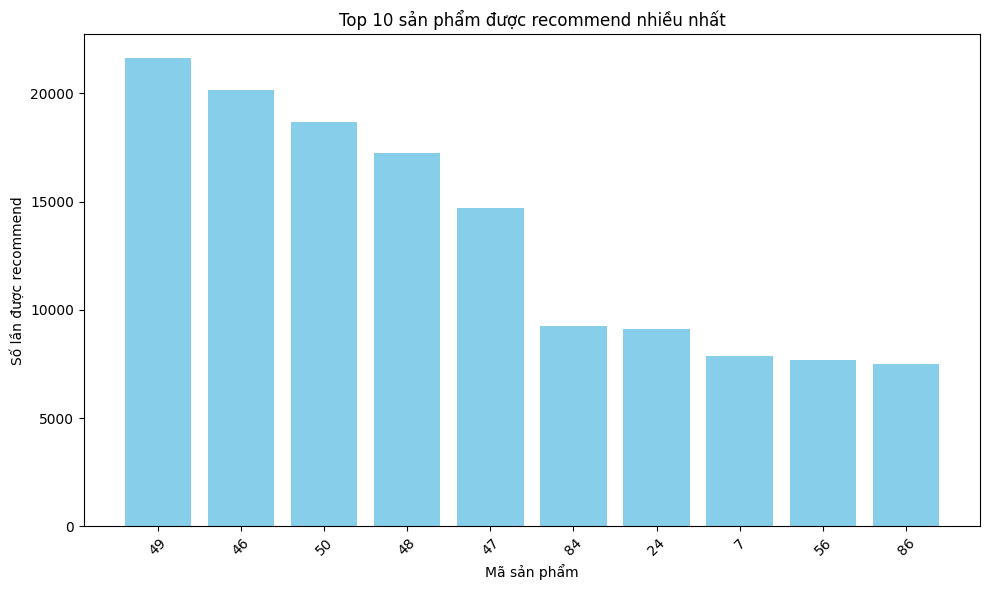

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Chuyển recommendations từ Spark DataFrame sang Pandas DataFrame
userRecs_pd = userRecs.select("recommendations.product_id").toPandas()

# Tạo danh sách tất cả các product_id được gợi ý
all_recommended_products = [product for sublist in userRecs_pd["product_id"] for product in sublist]

# Đếm số lần mỗi sản phẩm được gợi ý
product_counts = Counter(all_recommended_products)

# Chuyển kết quả thành DataFrame để vẽ biểu đồ
product_df = pd.DataFrame(product_counts.items(), columns=['product_id', 'count'])

# Sắp xếp theo số lần được gợi ý và lấy 10 sản phẩm top đầu
top_10_products = product_df.sort_values(by="count", ascending=False).head(10)

# Vẽ biểu đồ số lần 10 sản phẩm được recommend nhiều nhất
plt.figure(figsize=(10, 6))  # Điều chỉnh kích thước biểu đồ cho phù hợp với 10 sản phẩm
plt.bar(top_10_products['product_id'].astype(str), top_10_products['count'], color='skyblue')
plt.title('Top 10 sản phẩm được recommend nhiều nhất')
plt.xlabel('Mã sản phẩm')
plt.ylabel('Số lần được recommend')
plt.xticks(rotation=45)  # Xoay nhãn trên trục X nếu cần
plt.tight_layout()
plt.show()


In [ ]:
spark.stop()